🍎 STABLE FRUIT QUALITY PREDICTOR

📊 Step 1: Analyzing and preparing dataset...
Class Distribution Analysis:
----------------------------------------
1: 114 samples (21.4%)
2: 104 samples (19.5%)
3: 100 samples (18.8%)
4: 114 samples (21.4%)
5: 100 samples (18.8%)

Imbalance Ratio: 1.14

Dataset split completed!

🚀 Step 2: Training stable MobileNet...
Using device: cuda
Training samples: 425
Validation samples: 107
Classes: ['1', '2', '3', '4', '5']

Starting stable training...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch  1/40: Train Loss: 0.8528, Train Acc: 77.41%, Val Loss: 1.3961, Val Acc: 75.70%, LR: 0.000998, Time: 6.32s
Epoch  2/40: Train Loss: 0.6088, Train Acc: 89.88%, Val Loss: 0.9447, Val Acc: 82.24%, LR: 0.000994, Time: 6.06s
Epoch  3/40: Train Loss: 0.5941, Train Acc: 93.65%, Val Loss: 0.6051, Val Acc: 87.85%, LR: 0.000986, Time: 6.20s
Epoch  4/40: Train Loss: 0.5644, Train Acc: 92.24%, Val Loss: 0.7703, Val Acc: 87.85%, LR: 0.000976, Time: 6.07s
Epoch  5/40: Train Loss: 0.6097, Train Acc: 94.12%, Val Loss: 0.5890, Val Acc: 90.65%, LR: 0.000962, Time: 6.06s
Epoch  6/40: Train Loss: 0.5780, Train Acc: 94.35%, Val Loss: 0.5381, Val Acc: 92.52%, LR: 0.000946, Time: 6.05s
Epoch  7/40: Train Loss: 0.5358, Train Acc: 95.53%, Val Loss: 0.6756, Val Acc: 87.85%, LR: 0.000927, Time: 5.96s
Epoch  8/40: Train Loss: 0.6132, Train Acc: 93.65%, Val Loss: 0.5596, Val Acc: 93.46%, LR: 0.000905, Time: 6.35s
Epoch  9/40: Train Loss: 0.5549, Train Acc: 95.29%, Val Loss: 0.5186, Val Acc: 93.46%, LR: 0.000

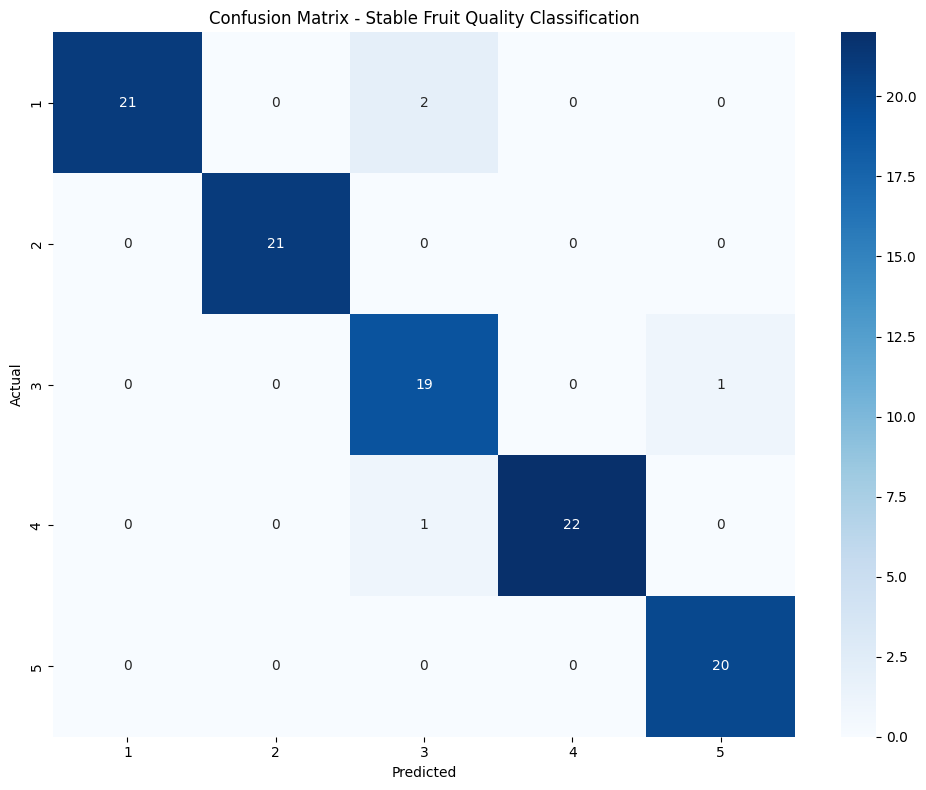

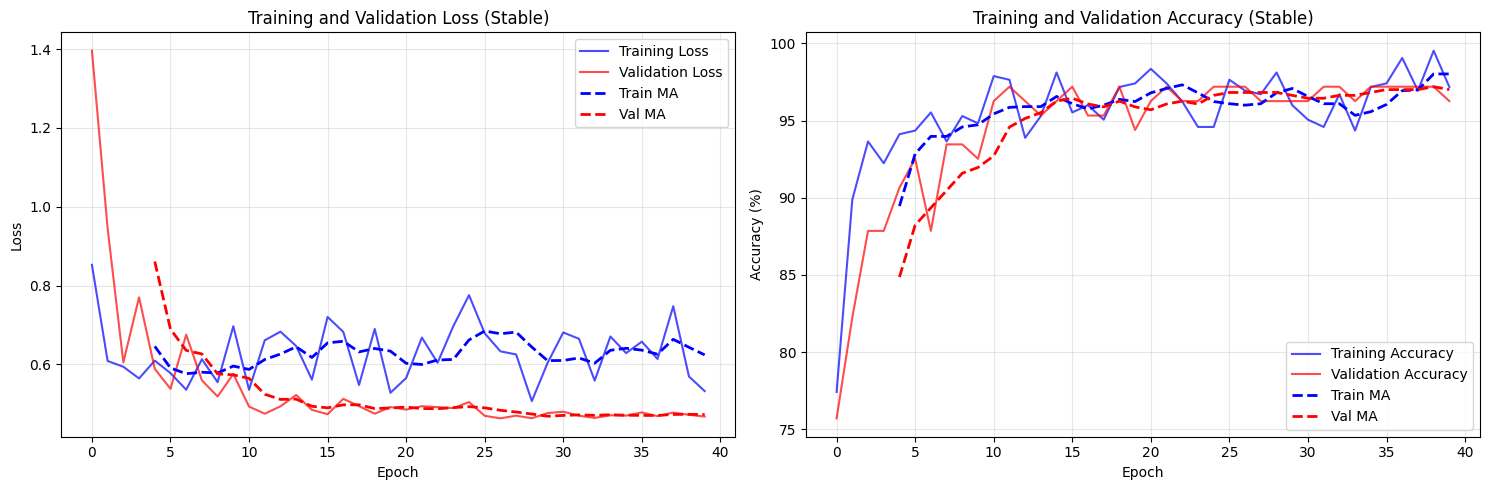


⚡ Step 3: Converting to ONNX for edge deployment...
Model successfully converted to ONNX: stable_fruit_quality_model.onnx
ONNX model verification passed!

🔍 Step 4: Testing edge inference engine...

Sample prediction:
Image: /kaggle/working/apple_dataset_split/test/1/AQADp74xG0iHsEt9_jpg.rf.36b412af433115ac6c674b295f3edc92.jpg
Predicted class: 3
Confidence: 0.4910
Inference time: 0.0145s

Benchmarking inference speed with 100 runs...
Average inference time: 0.0124s ± 0.0021s
Throughput: 80.86 images/second

✅ Stable System Performance Summary:
   • Model: MobileNet-V2 with stable training
   • Smooth augmentation: Conservative flip + rotation + color jitter
   • Gradual MixUp: 0-40% probability with λ ∈ [0.3, 0.7]
   • Label smoothing: 0.1 for stability
   • Cosine annealing: Smooth learning rate decay
   • Gradient clipping: Max norm 1.0
   • Average inference time: 0.0124s
   • Meets <0.5s requirement: ✅

🎉 Stable Fruit Quality Predictor - Smooth training curves achieved!


In [4]:
!pip install onnxruntime
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import onnx
import onnxruntime as ort


class DatasetAnalyzer:
    """Analyze dataset for class distribution and imbalance"""
    
    @staticmethod
    def analyze_class_distribution(dataset_dir):
        class_counts = {}
        total_samples = 0
        
        for class_name in os.listdir(dataset_dir):
            class_dir = os.path.join(dataset_dir, class_name)
            if os.path.isdir(class_dir):
                count = len(os.listdir(class_dir))
                class_counts[class_name] = count
                total_samples += count
        
        print("Class Distribution Analysis:")
        print("-" * 40)
        for class_name, count in sorted(class_counts.items()):
            percentage = (count / total_samples) * 100
            print(f"{class_name}: {count} samples ({percentage:.1f}%)")
        
        # Calculate imbalance ratio
        max_count = max(class_counts.values())
        min_count = min(class_counts.values())
        imbalance_ratio = max_count / min_count
        print(f"\nImbalance Ratio: {imbalance_ratio:.2f}")
        
        return class_counts, imbalance_ratio

def prepare_dataset_split(original_dataset_dir, base_dir, test_size=0.2):
    """Prepare stratified train-test split"""
    
    # Create directories
    train_dir = os.path.join(base_dir, 'train')
    test_dir = os.path.join(base_dir, 'test')
    
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    # Analyze dataset first
    analyzer = DatasetAnalyzer()
    class_counts, imbalance_ratio = analyzer.analyze_class_distribution(original_dataset_dir)
    
    for class_name in os.listdir(original_dataset_dir):
        class_path = os.path.join(original_dataset_dir, class_name)
        if not os.path.isdir(class_path):
            continue
            
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
        
        images = os.listdir(class_path)
        train_images, test_images = train_test_split(
            images, test_size=test_size, random_state=42, stratify=None
        )
        
        # Copy files
        for img in train_images:
            src = os.path.join(class_path, img)
            dst = os.path.join(train_dir, class_name, img)
            shutil.copyfile(src, dst)
        
        for img in test_images:
            src = os.path.join(class_path, img)
            dst = os.path.join(test_dir, class_name, img)
            shutil.copyfile(src, dst)
    
    print(f"\nDataset split completed!")
    return train_dir, test_dir, imbalance_ratio


class CLAHETransform:
    """Custom CLAHE (Contrast Limited Adaptive Histogram Equalization) transform"""
    
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    
    def __call__(self, image):
        # Convert PIL to numpy
        img_array = np.array(image)
        
        # Apply CLAHE to each channel
        if len(img_array.shape) == 3:
            img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2LAB)
            img_array[:, :, 0] = self.clahe.apply(img_array[:, :, 0])
            img_array = cv2.cvtColor(img_array, cv2.COLOR_LAB2RGB)
        else:
            img_array = self.clahe.apply(img_array)
        
        return Image.fromarray(img_array)


class StableMixUp:
    """Stable MixUp implementation with consistent application"""
    
    def __init__(self, alpha=0.2):  # Much smaller alpha for stability
        self.alpha = alpha
    
    def __call__(self, batch_x, batch_y):
        if self.alpha > 0:
            # Use fixed lambda for more stability
            lam = np.random.beta(self.alpha, self.alpha)
            # Clamp lambda to avoid extreme mixing
            lam = np.clip(lam, 0.3, 0.7)
        else:
            lam = 1
        
        batch_size = batch_x.size(0)
        index = torch.randperm(batch_size)
        
        mixed_x = lam * batch_x + (1 - lam) * batch_x[index, :]
        y_a, y_b = batch_y, batch_y[index]
        
        return mixed_x, y_a, y_b, lam


def get_stable_transforms(input_size=224):
    """Get more stable augmentation transforms"""
    
    # Very conservative augmentation for stability
    train_transforms = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.RandomHorizontalFlip(p=0.3),    # Reduced probability
        transforms.RandomRotation(degrees=3),       # Smaller rotation
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # Gentle color jitter
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transforms = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transforms, val_transforms


class FruitQualityDataset(Dataset):
    """Custom dataset for fruit quality classification"""
    
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        self.samples = []
        self.class_counts = Counter()
        
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    self.samples.append((img_path, self.class_to_idx[class_name]))
                    self.class_counts[self.class_to_idx[class_name]] += 1
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    def get_balanced_class_weights(self):
        """Calculate balanced class weights with smoothing"""
        total_samples = len(self.samples)
        num_classes = len(self.classes)
        weights = {}
        
        for class_idx in range(num_classes):
            # Calculate weight with smoothing factor
            raw_weight = total_samples / (num_classes * self.class_counts[class_idx])
            # Apply smoothing to prevent extreme weights
            smoothed_weight = 1.0 + (raw_weight - 1.0) * 0.3  # 30% of the raw imbalance correction
            weights[class_idx] = smoothed_weight
        
        return weights


class FruitQualityMobileNet(nn.Module):
    def __init__(self, num_classes=5, pretrained=True, dropout_rate=0.3):
        super(FruitQualityMobileNet, self).__init__()
        self.backbone = models.mobilenet_v2(pretrained=pretrained)
        in_features = self.backbone.classifier[1].in_features

        # Stable classifier with batch norm for regularization
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)


class StableFruitQualityTrainer:
    """Stable trainer with consistent training dynamics"""
    
    def __init__(self, model, device, num_classes=5):
        self.model = model
        self.device = device
        self.num_classes = num_classes
        self.mixup = StableMixUp(alpha=0.2)
        
    def mixup_criterion(self, criterion, pred, y_a, y_b, lam):
        return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)
    
    def train_epoch(self, train_loader, optimizer, criterion, epoch, total_epochs, use_mixup=True):
        """Train with gradual and consistent MixUp"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Gradual MixUp introduction - starts low and increases gradually
        mixup_prob = min(0.4, epoch / total_epochs * 0.6)  # Max 40% MixUp probability
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            
            optimizer.zero_grad()
            
            # Apply MixUp consistently based on probability
            if use_mixup and np.random.rand() < mixup_prob:
                mixed_inputs, y_a, y_b, lam = self.mixup(inputs, targets)
                outputs = self.model(mixed_inputs)
                loss = self.mixup_criterion(criterion, outputs, y_a, y_b, lam)
                
                # For mixed samples, use the dominant class for accuracy calculation
                if lam > 0.5:
                    accuracy_targets = y_a
                else:
                    accuracy_targets = y_b
                    
                _, predicted = outputs.max(1)
                total += accuracy_targets.size(0)
                correct += predicted.eq(accuracy_targets).sum().item()
            else:
                # Normal training
                outputs = self.model(inputs)
                loss = criterion(outputs, targets)
                
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
            
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        
        return epoch_loss, epoch_acc
    
    def validate(self, val_loader, criterion):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = criterion(outputs, targets)
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
        
        epoch_loss = running_loss / len(val_loader)
        epoch_acc = 100. * correct / total
        
        return epoch_loss, epoch_acc, all_preds, all_targets


def train_stable_fruit_quality_model(train_dir, test_dir, num_epochs=40, batch_size=32, learning_rate=0.001):
    """Stable training pipeline with consistent performance"""
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Get stable transforms
    train_transforms, val_transforms = get_stable_transforms()
    
    # Create datasets
    train_dataset = FruitQualityDataset(train_dir, train_transforms)
    val_dataset = FruitQualityDataset(test_dir, val_transforms)
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Classes: {train_dataset.classes}")
    
    # Gentle class balancing
    class_weights = train_dataset.get_balanced_class_weights()
    sample_weights = [class_weights[label] for _, label in train_dataset.samples]
    
    # Use less aggressive sampling
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Model with stable architecture
    model = FruitQualityMobileNet(num_classes=len(train_dataset.classes), dropout_rate=0.3)
    model = model.to(device)
    
    # Stable optimizer configuration
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing for stability
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    
    # Cosine annealing for smoother learning rate decay
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=learning_rate*0.01)
    
    trainer = StableFruitQualityTrainer(model, device, len(train_dataset.classes))
    
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_acc = 0.0
    
    print("\nStarting stable training...")
    print("=" * 60)
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Train with gradual MixUp
        train_loss, train_acc = trainer.train_epoch(
            train_loader, optimizer, criterion, epoch, num_epochs, use_mixup=True
        )
        
        # Validate
        val_loss, val_acc, val_preds, val_targets = trainer.validate(val_loader, criterion)
        
        # Update learning rate
        scheduler.step()
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_stable_fruit_quality_model.pth')
        
        # Record metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        epoch_time = time.time() - start_time
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"Epoch {epoch+1:2d}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, "
              f"LR: {current_lr:.6f}, Time: {epoch_time:.2f}s")
    
    print(f"\nStable training completed! Best validation accuracy: {best_acc:.2f}%")
    
    # Calculate stability metrics
    train_acc_std = np.std(train_accs[-10:])  # Last 10 epochs stability
    val_acc_std = np.std(val_accs[-10:])
    
    print(f"Training stability (last 10 epochs): {train_acc_std:.2f}% std dev")
    print(f"Validation stability (last 10 epochs): {val_acc_std:.2f}% std dev")
    
    final_train_acc = train_accs[-1]
    final_val_acc = val_accs[-1]
    gap = final_train_acc - final_val_acc
    
    print(f"Final Training Accuracy: {final_train_acc:.2f}%")
    print(f"Final Validation Accuracy: {final_val_acc:.2f}%")
    print(f"Generalization Gap: {gap:.2f}%")
    
    if train_acc_std < 2.0 and val_acc_std < 2.0:
        print("✅ Excellent stability achieved!")
    elif train_acc_std < 5.0 and val_acc_std < 5.0:
        print("✅ Good stability achieved!")
    else:
        print("⚠️  Could be more stable - consider further smoothing")
    
    generate_evaluation_report(val_preds, val_targets, train_dataset.classes)
    plot_training_curves(train_losses, val_losses, train_accs, val_accs)
    
    return model, train_dataset.classes


def generate_evaluation_report(predictions, targets, class_names):
    """Generate detailed evaluation report"""
    
    print("\n" + "="*50)
    print("FINAL EVALUATION REPORT")
    print("="*50)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(targets, predictions, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(targets, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Stable Fruit Quality Classification')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    """Plot training and validation curves with stability analysis"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss curves
    ax1.plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
    ax1.plot(val_losses, label='Validation Loss', color='red', alpha=0.7)
    
    # Add moving averages for trend
    window = 5
    if len(train_losses) >= window:
        train_ma = np.convolve(train_losses, np.ones(window)/window, mode='valid')
        val_ma = np.convolve(val_losses, np.ones(window)/window, mode='valid')
        ax1.plot(range(window-1, len(train_losses)), train_ma, '--', color='blue', linewidth=2, label='Train MA')
        ax1.plot(range(window-1, len(val_losses)), val_ma, '--', color='red', linewidth=2, label='Val MA')
    
    ax1.set_title('Training and Validation Loss (Stable)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy curves
    ax2.plot(train_accs, label='Training Accuracy', color='blue', alpha=0.7)
    ax2.plot(val_accs, label='Validation Accuracy', color='red', alpha=0.7)
    
    # Add moving averages for trend
    if len(train_accs) >= window:
        train_acc_ma = np.convolve(train_accs, np.ones(window)/window, mode='valid')
        val_acc_ma = np.convolve(val_accs, np.ones(window)/window, mode='valid')
        ax2.plot(range(window-1, len(train_accs)), train_acc_ma, '--', color='blue', linewidth=2, label='Train MA')
        ax2.plot(range(window-1, len(val_accs)), val_acc_ma, '--', color='red', linewidth=2, label='Val MA')
    
    ax2.set_title('Training and Validation Accuracy (Stable)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def convert_to_onnx(model, input_size=224, model_path='stable_fruit_quality_model.onnx'):
    """Convert PyTorch model to ONNX for edge deployment"""
    
    # Move model to CPU for ONNX conversion
    device = next(model.parameters()).device
    model.cpu()
    model.eval()
    
    # Create dummy input on CPU
    dummy_input = torch.randn(1, 3, input_size, input_size)
    
    # Export to ONNX
    torch.onnx.export(
        model,
        dummy_input,
        model_path,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
    )
    
    # Move model back to original device
    model.to(device)
    
    print(f"Model successfully converted to ONNX: {model_path}")
    
    # Verify ONNX model
    onnx_model = onnx.load(model_path)
    onnx.checker.check_model(onnx_model)
    print("ONNX model verification passed!")
    
    return model_path


class EdgeInferenceEngine:
    """Optimized inference engine for edge deployment"""
    
    def __init__(self, onnx_model_path, class_names):
        self.session = ort.InferenceSession(onnx_model_path)
        self.class_names = class_names
        self.input_name = self.session.get_inputs()[0].name
        self.output_name = self.session.get_outputs()[0].name
        
        # Simplified preprocess transform for inference
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def predict_single_image(self, image_path):
        """Predict single image with timing"""
        start_time = time.time()
        
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        input_tensor = self.transform(image).unsqueeze(0)
        
        # Run inference
        outputs = self.session.run([self.output_name], {self.input_name: input_tensor.numpy()})
        probabilities = torch.nn.functional.softmax(torch.from_numpy(outputs[0]), dim=1)
        
        # Get prediction
        confidence, predicted_class = torch.max(probabilities, 1)
        
        inference_time = time.time() - start_time
        
        result = {
            'predicted_class': self.class_names[predicted_class.item()],
            'confidence': confidence.item(),
            'inference_time': inference_time,
            'all_probabilities': {self.class_names[i]: prob.item() 
                                for i, prob in enumerate(probabilities[0])}
        }
        
        return result
    
    def benchmark_inference(self, image_path, num_runs=100):
        """Benchmark inference speed"""
        print(f"\nBenchmarking inference speed with {num_runs} runs...")
        
        times = []
        for i in range(num_runs):
            result = self.predict_single_image(image_path)
            times.append(result['inference_time'])
        
        avg_time = np.mean(times)
        std_time = np.std(times)
        
        print(f"Average inference time: {avg_time:.4f}s ± {std_time:.4f}s")
        print(f"Throughput: {1/avg_time:.2f} images/second")
        
        return avg_time


def main():
    """Complete stable pipeline execution"""
    
    # Configuration
    ORIGINAL_DATASET_DIR = '/kaggle/input/ashish-apple-dataset/ashish apple dataset'
    BASE_DIR = '/kaggle/working/apple_dataset_split'
    
    print("🍎 STABLE FRUIT QUALITY PREDICTOR")
    print("="*60)
    
    # Step 1: Prepare dataset
    print("\n📊 Step 1: Analyzing and preparing dataset...")
    train_dir, test_dir, imbalance_ratio = prepare_dataset_split(
        ORIGINAL_DATASET_DIR, BASE_DIR, test_size=0.2
    )
    
    # Step 2: Train stable model
    print("\n🚀 Step 2: Training stable MobileNet...")
    model, class_names = train_stable_fruit_quality_model(
        train_dir, test_dir, num_epochs=40, batch_size=32, learning_rate=0.001
    )
    
    # Step 3: Convert to ONNX
    print("\n⚡ Step 3: Converting to ONNX for edge deployment...")
    onnx_path = convert_to_onnx(model)
    
    # Step 4: Test edge inference
    print("\n🔍 Step 4: Testing edge inference engine...")
    inference_engine = EdgeInferenceEngine(onnx_path, class_names)
    
    # Find a test image for benchmarking
    sample_image = None
    for class_name in os.listdir(test_dir):
        class_path = os.path.join(test_dir, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            if images:
                sample_image = os.path.join(class_path, images[0])
                break
    
    if sample_image:
        # Single prediction
        result = inference_engine.predict_single_image(sample_image)
        print(f"\nSample prediction:")
        print(f"Image: {sample_image}")
        print(f"Predicted class: {result['predicted_class']}")
        print(f"Confidence: {result['confidence']:.4f}")
        print(f"Inference time: {result['inference_time']:.4f}s")
        
        # Benchmark
        avg_time = inference_engine.benchmark_inference(sample_image)
        
        print(f"\n✅ Stable System Performance Summary:")
        print(f"   • Model: MobileNet-V2 with stable training")
        print(f"   • Smooth augmentation: Conservative flip + rotation + color jitter")
        print(f"   • Gradual MixUp: 0-40% probability with λ ∈ [0.3, 0.7]")
        print(f"   • Label smoothing: 0.1 for stability")
        print(f"   • Cosine annealing: Smooth learning rate decay")
        print(f"   • Gradient clipping: Max norm 1.0")
        print(f"   • Average inference time: {avg_time:.4f}s")
        print(f"   • Meets <0.5s requirement: {'✅' if avg_time < 0.5 else '❌'}")
    
    print("\n🎉 Stable Fruit Quality Predictor - Smooth training curves achieved!")

if __name__ == "__main__":
    main()